# 전력 수요량 예측 모델링_3
##### 20191023 - 
##### 예측 해보기
Train 데이터로 모델을 학습, 검증 후 Test로 예측합니다.

 - ML 방법
    1. https://www.kaggle.com/fkstepz/step-by-step-house-prices-prediction

In [2]:
# import package
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime, timedelta
%matplotlib inline

## 1. 데이터 불러오기

In [45]:
# 랜덤하게 뽑은 260세대에 선형보간법을 적용한 데이터
pre_train_1 = pd.read_csv("interpolation_1.csv")
#train['Time'] = pd.to_datetime(train['Time'])
#train = train.set_index('Time')

In [5]:
pre_train_1

,Time,X1472,X115,X1226,X273,X339,X774,X857,X1075,X1061,...,X933,X1238,X394,X829,X432,X1334,X1416,X803,X45,X1205
0,2016-07-26 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16904,2018-06-30 19:00:00,0.331,1.325,0.356,0.329,0.330,0.756,0.694,0.172,1.010,...,0.222,0.285,0.262,0.644,0.277,0.689,0.835,0.879,NaN,0.281
16905,2018-06-30 20:00:00,0.404,1.218,0.346,0.335,0.387,0.445,0.912,0.734,0.681,...,0.222,0.301,0.287,0.720,0.300,0.832,0.435,0.408,NaN,0.245
16906,2018-06-30 21:00:00,0.379,1.100,0.302,0.291,0.446,0.386,0.844,0.934,0.548,...,0.222,0.297,0.292,0.694,0.305,0.484,0.487,0.636,NaN,0.483
16907,2018-06-30 22:00:00,0.553,1.094,0.233,0.278,0.385,0.393,0.840,0.715,0.589,...,0.222,0.406,0.258,0.582,0.233,0.781,0.318,0.504,NaN,0.467


In [8]:
# 모든 행이 NaN인 세대 수 1301-1293=8세대
NaN_list = set(pre_train_1.dropna(how='all', axis=1).keys())
set(pre_train_1.keys()).difference(NaN_list)

NaN_X = set(pre_train_1.keys()).difference(NaN_list)

In [44]:
pre_train_1.keys()

Index(['X1472', 'X115', 'X1226', 'X273', 'X339', 'X774', 'X857', 'X1075',
       'X1061', 'X1091',
       ...
       'X933', 'X1238', 'X394', 'X829', 'X432', 'X1334', 'X1416', 'X803',
       'X45', 'X1205'],
      dtype='object', length=260)

In [9]:
# 결측치가 아닌 행의 위치 DF
first_notnull_2 = []  # 빈 list

for i in pre_train_1.keys()[1:]:
    if i not in NaN_X:
       _ = pre_train_1[i]
       first_notnull_2.append(_[_.isnull() == False].index[0])
    else:
        first_notnull_2.append(0)
        
df_notnull_2 = pd.DataFrame(first_notnull_2, list(pre_train_1.keys()[1:]))
df_notnull_2.columns = ['not_blank_num']

In [39]:
df_notnull_2

,not_blank_num
X1472,13645
X115,219
X1226,13645
X273,9600
X339,9575
...,...
X1334,13645
X1416,13645
X803,13645
X45,0


In [25]:
pd.Series(first_notnull_2).value_counts()

13645    212
9575      14
9600       9
15152      7
9623       3
9469       3
219        3
9624       2
0          2
9590       1
9574       1
13634      1
9485       1
9334       1
dtype: int64

In [37]:
df_notnull_2[df_notnull_2['not_blank_num'] != 13645].count()

not_blank_num    48
dtype: int64

In [10]:
# index Time으로 고정
pre_train_1 = pre_train_1.set_index('Time')

## ARIMA
1. https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051
2. https://byeongkijeong.github.io/ARIMA-with-Python/

In [26]:
start_num

13645

In [13]:
start_num = df_notnull_2.loc['X1226'][0]
pre_train_1[['X1226']][start_num:]

,X1226
Time,
2018-02-15 00:00:00,0.029
2018-02-15 01:00:00,0.079
2018-02-15 02:00:00,0.083
2018-02-15 03:00:00,0.085
2018-02-15 04:00:00,0.087
...,...
2018-06-30 19:00:00,0.356
2018-06-30 20:00:00,0.346
2018-06-30 21:00:00,0.302


In [46]:
X1226_df = pd.DataFrame(pre_train_1[['X1226']][start_num:])
X1226_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 13645 to 16908
Data columns (total 1 columns):
X1226    3264 non-null float64
dtypes: float64(1)
memory usage: 25.6 KB


In [52]:
# Train, Test 개수 구하기
print("Train 개수 :", round(X1226_df.shape[0]*0.7))
print("Test  개수 :", X1226_df.shape[0] - round(X1226_df.shape[0]*0.7))

Train 개수 : 2285
Test  개수 : 979


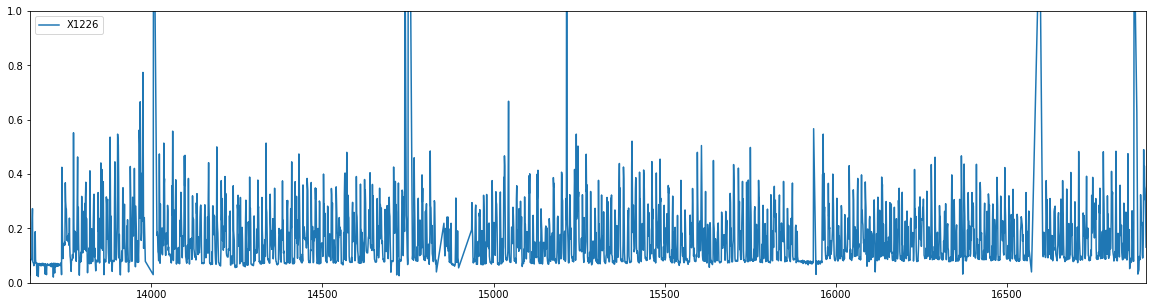

In [68]:
# split train test
X1226_train = df.iloc[:-979, :]
X1226_test = df.iloc[-979:, :]

# set index to timedata
X1226_train.index = pd.to_datetime(X1226_train.index)
X1226_test.index = pd.to_datetime(X1226_test.index)

# predict
X1226_pred = X1226_test.copy()

X1226_df.plot(figsize=(20,5))
plt.ylim(0,1)
plt.show()

## 시계열분석
https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

In [67]:
# package load
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [69]:
# Forecast quality metrics
# R2 : sklearn.metrics.r2_score
# MAE : sklearn.metrics.mean_absolute_error
# MedAE : sklearn.metrics.median_absolute_error
# MSE : sklearn.metrics.mean_squared_error
# MSLE : sklearn.metrics.mean_squared_log_error
# MAPE : def mean_absolute_percentage_error(y_true, y_pred): 
#    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## XGBoost
: tree-based모델로, train에서 발견된 값 중 최대값 이상의 값(최소값 이하의 값)을 추론,예측할 수 없음. 

이를 해결하기 위해서는 trend를 제거하거나, series를 stationary하도록 만들어야 함

* 이외에 고려할만한 ML모델 : SVM, RF, MLP

In [ ]:
from xgboost import XGBRegressor 

xgb = XGBRegressor(verbosity=0)
xgb.fit(X_train_scaled, y_train);